In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

from sklearn.tree import export_text

from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_extraction import DictVectorizer

from sklearn.ensemble import RandomForestRegressor

from IPython.display import display

from sklearn.metrics import mean_squared_error

from matplotlib import pyplot as plt
import xgboost as xgb

In [2]:
#!wget 'https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv'

In [3]:
df = pd.read_csv('housing.csv')
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [4]:
price_logs = np.log1p(df.median_house_value)

In [5]:
df = df.fillna(0)

In [6]:
df.isnull().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64

In [7]:
df = df[(df['ocean_proximity'] == '<1H OCEAN')].replace('<1H OCEAN', 'less1H OCEAN')

In [8]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [9]:
y_train = np.log1p(df_train.median_house_value.values)
y_val = np.log1p(df_val.median_house_value.values)
y_test = np.log1p(df_test.median_house_value.values)

del df_train['median_house_value']
del df_val['median_house_value']
del df_test['median_house_value']

In [10]:
train_dicts = df_train.to_dict(orient='records')
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)

In [11]:
val_dicts= df_val.to_dict(orient='records')
X_val = dv.transform(val_dicts)

## Question 1

Let's train a decision tree regressor to predict the median_house_value variable.

Train a model with max_depth=1.
Which feature is used for splitting the data?

- **ocean_proximity=INLAND <-**
- total_rooms
- latitude
- population


In [12]:
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1)

In [13]:
#Decision stump
tree_text = export_text(dt, feature_names=dv.feature_names_)
print(tree_text)

|--- median_income <= 5.05
|   |--- value: [12.14]
|--- median_income >  5.05
|   |--- value: [12.68]



**Answer Question 1:** ocean_proximity=INLAND

## Question 2

Train a random forest model with these parameters:

n_estimators=10
random_state=1
n_jobs=-1 (optional - to make training faster)
What's the RMSE of this model on validation?

- 0.05
- **0.25 <-** 
- 0.55
- 0.85


In [14]:
rf = RandomForestRegressor(n_estimators=10, random_state=1)
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, random_state=1)

In [15]:
y_pred = rf.predict(X_val)

In [16]:
def rmse(y, y_pred):
    error = y_pred - y
    mse = (error ** 2).mean()
    return np.sqrt(mse)

In [17]:
np.round(rmse(y_val, y_pred),2)

0.23

In [18]:
np.round(np.sqrt(mean_squared_error(y_val, y_pred)),2)

0.23

**Answer Question 2:** 0.25

## Question 3
Now let's experiment with the n_estimators parameter

Try different values of this parameter from 10 to 200 with step 10.
Set random_state to 1.
Evaluate the model on the validation dataset.

After which value of n_estimators does RMSE stop improving?

- 10
- 55
- 75
- **150 <-**

In [19]:
from tqdm.auto import tqdm

In [20]:
scores = []

for n in tqdm(range(10, 201, 10)):
    rf = RandomForestRegressor(n_estimators=n,
                                random_state=1,
                                n_jobs=-1)
    rf.fit(X_train, y_train)
    
    y_pred = rf.predict(X_val)
    score = np.sqrt(mean_squared_error(y_val, y_pred))
    scores.append((n, score))

  0%|          | 0/20 [00:00<?, ?it/s]

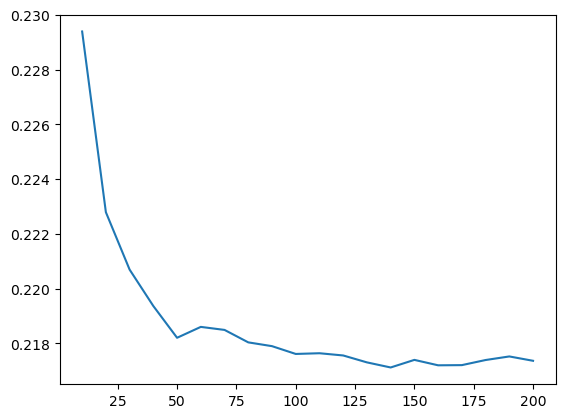

In [21]:
columns = ['n_estimators','rmse']
df_scores = pd.DataFrame(scores, columns=columns)
plt.plot(df_scores.n_estimators, df_scores.rmse)
plt.show()

**Answer Question 3:** 150

## Question 4
Let's select the best max_depth:

Try different values of max_depth: [10, 15, 20, 25]

For each of these values, try different values of n_estimators from 10 till 200 (with step 10).Fix the random seed: random_state=1

What's the best max_depth:

- 10
- 15
- 20
- **25 <-**

In [22]:
scores = []

for d in tqdm([10, 15, 20, 25]):
    
    for n in tqdm(range(10, 201, 10)):
        
        rf = RandomForestRegressor(n_estimators=n,
                                        max_depth=d,
                                        random_state=1,
                                        n_jobs=-1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict(X_val)
        score = np.sqrt(mean_squared_error(y_val, y_pred))
        scores.append((n, d, score))

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

In [23]:
columns = ['n_estimators', 'max_depth', 'rmse']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores

,n_estimators,max_depth,rmse
0,10,10,0.236704
1,20,10,0.233015
2,30,10,0.232234
3,40,10,0.231301
4,50,10,0.230389
...,...,...,...
75,160,25,0.217467
76,170,25,0.217496
77,180,25,0.217660
78,190,25,0.217810


In [24]:
#for d in [10, 15, 20, 25]:
    #test = df_scores[df_scores.max_depth == d]
    #print(test)

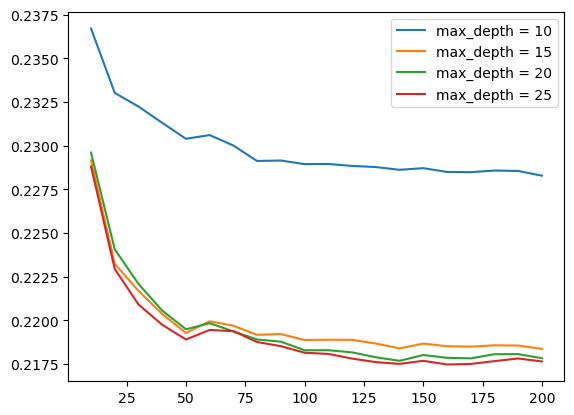

In [25]:
for d in [10, 15, 20, 25]:
    df_subset = df_scores[df_scores.max_depth == d]
    plt.plot(df_subset.n_estimators, df_subset.rmse, label=f'max_depth = {d}')
    
plt.legend()
plt.show()

**Answer Question 4:** 25

## Question 5

We can extract feature importance information from tree-based models.

At each step of the decision tree learning algorith, it finds the best split. When doint it, we can calculate "gain" - the reduction in impurity before and after the split. This gain is quite useful in understanding what are the imporatant features for tree-based models.

In Scikit-Learn, tree-based models contain this information in the feature_importances_ field.

For this homework question, we'll find the most important feature:

Train the model with these parametes:
- n_estimators=10,
- max_depth=20,
- random_state=1,
- n_jobs=-1 (optional)

Get the feature importance information from this model

What's the most important feature?

- total_rooms
- **median_income <-**
- total_bedrooms
- longitude


In [26]:
scores= []

rf = RandomForestRegressor(n_estimators=10,
                            random_state=1,
                            max_depth=20,
                            n_jobs=-1)
rf.fit(X_train, y_train)

rf.feature_importances_


array([0.02283962, 0.04375567, 0.16378253, 0.15346025, 0.52132401,
       0.        , 0.03811088, 0.02260739, 0.03411965])

In [27]:
df_importances = pd.DataFrame()
df_importances['feature'] = dv.get_feature_names_out()
df_importances['importance'] = rf.feature_importances_
df_importances.sort_values(by='importance', ascending=False).head(3)

,feature,importance
4,median_income,0.521324
2,latitude,0.163783
3,longitude,0.153460


**Answer Question 5:** median_income

## Question 6

Now let's train an XGBoost model! For this question, we'll tune the eta parameter:

Install XGBoost
Create DMatrix for train and validation
Create a watchlist
Train a model with these parameters for 100 rounds:
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

Now change eta first to 0.1 and then to 0.01

Which eta leads to the best RMSE score on the validation dataset?

- 0.3
- **0.1 <-**
- Both gives same

In [28]:
df

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
701,-121.97,37.64,32.0,1283.0,194.0,485.0,171.0,6.0574,431000.0,less1H OCEAN
830,-121.99,37.61,9.0,3666.0,711.0,2341.0,703.0,4.6458,217000.0,less1H OCEAN
859,-121.97,37.57,21.0,4342.0,783.0,2172.0,789.0,4.6146,247600.0,less1H OCEAN
860,-121.96,37.58,15.0,3575.0,597.0,1777.0,559.0,5.7192,283500.0,less1H OCEAN
861,-121.98,37.58,20.0,4126.0,1031.0,2079.0,975.0,3.6832,216900.0,less1H OCEAN
...,...,...,...,...,...,...,...,...,...,...
20502,-118.68,34.33,45.0,121.0,25.0,67.0,27.0,2.9821,325000.0,less1H OCEAN
20503,-118.75,34.33,27.0,534.0,85.0,243.0,77.0,8.2787,330000.0,less1H OCEAN
20504,-118.73,34.29,11.0,5451.0,736.0,2526.0,752.0,7.3550,343900.0,less1H OCEAN
20505,-118.72,34.29,22.0,3266.0,529.0,1595.0,494.0,6.0368,248000.0,less1H OCEAN


In [29]:
features = dv.get_feature_names_out()
features

array(['households', 'housing_median_age', 'latitude', 'longitude',
       'median_income', 'ocean_proximity=less1H OCEAN', 'population',
       'total_bedrooms', 'total_rooms'], dtype=object)

In [34]:
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [69]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')
        
        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])
        
        results.append((it, train, val))
    
    columns = ['num_iter', 'train_rmse', 'val_rsme']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [70]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [71]:
scores_eta = {}

In [78]:
%%capture output
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain,
                  evals=watchlist,
                  num_boost_round=100)

In [79]:
key_text_eta = f"eta = {xgb_params['eta']}"
scores_eta[key_text_eta] = parse_xgb_output(output)
key_text_eta

'eta = 0.3'

In [80]:
scores_eta.keys()

dict_keys(['eta = 0.1', 'eta = 0.01', 'eta = 0.3'])

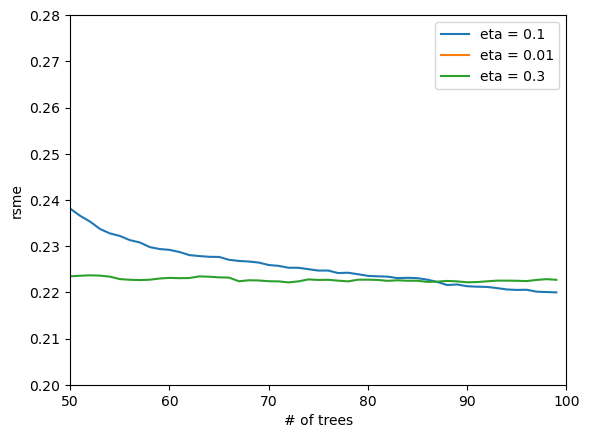

In [271]:
for key_eta, df_score in scores_eta.items():
    plt.plot(df_score.num_iter, df_score.val_rsme, label=key_eta)

plt.ylabel('rsme')
plt.xlabel('# of trees')

plt.xlim((50, 100))
plt.ylim((.20, .28))
plt.legend()
plt.show()


#0.3 less trees, achieve the same performance with 10 trees vs. eta 0.1 with 40 trees
#model is faster.

**Answer Question 6:** 0.1